# Comparing to Baseline

In [1]:
import os
import json
import tqdm
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from llm_elicited_priors.plotting import graph_theme
from llm_elicited_priors.utils import load_nested_dict_to_pandas

import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [2]:
width = 7.1413/0.75
colwidth = 3.433071
linewidth = 7.12598

In [3]:
RESULTS_PATH = Path(os.path.join("results", "elicitation"))
GENERATED_DATA_RESULTS_PATH = Path(os.path.join("results", "generated_data_mcmc"))

In [4]:
number_of_labels_to_plot = [5, 10, 20, 30, 40, 50]

Loading results

In [5]:
def load_result_dicts(path: Path):
    results_files = [
        f for f in os.listdir(path) 
        if (f.endswith(".json") and f.startswith("prior_no_prior"))
    ]
    print(f"Loading {len(results_files)} files from {path}")
    results_dicts = [
        json.load(open(os.path.join(path, f), "r"))
        for f in results_files
    ]

    return results_files, results_dicts

In [6]:
def result_dicts_to_df(results_files, results_dicts):
    results_dfs = [
        load_nested_dict_to_pandas(
            results_dict, level_names=["dataset", "run", "n_data_points_seen", "prior_type"]
        ).assign(results_file_name=results_file_name)
        
        for results_dict, results_file_name in zip(results_dicts, results_files)
    ]

    results_df = pd.concat(
        results_dfs
    ).astype(
        {
            "n_data_points_seen": int,
        }
    )

    return results_df

In [7]:
# results directory for each model
model_results_dir_dict = {
    "gpt_prior": "gpt-3-5-turbo-0125",
    "uninformative": "uninformative",
    "gpt_4_turbo_prior": "gpt-4-turbo-2024-04-09",
    # "deepseek_32b_q4": "deepseek-r1-32b-int4",
}

results_df = pd.DataFrame()

for model_name, model_results_dir in tqdm.tqdm(
    model_results_dir_dict.items(), desc="Loading results"
):
    results_df = pd.concat(
        [
            results_df,
            # loading the results from the dictionaries to a dataframe
            result_dicts_to_df(
                # loading the files to dictionaries
                *load_result_dicts(RESULTS_PATH.joinpath(model_results_dir))
            ).replace(
                # adding the model name
                {"prior_type": {"informative": model_name}}
            )
        ]
    )

Loading results:   0%|          | 0/3 [00:00<?, ?it/s]

Loading 80 files from results/elicitation/gpt-3-5-turbo-0125


Loading results:  33%|███▎      | 1/3 [00:03<00:06,  3.20s/it]

Loading 80 files from results/elicitation/uninformative


Loading results:  67%|██████▋   | 2/3 [00:06<00:03,  3.16s/it]

Loading 80 files from results/elicitation/gpt-4-turbo-2024-04-09


Loading results: 100%|██████████| 3/3 [00:09<00:00,  3.21s/it]


In [8]:
# results directory for each model
model_results_dir_dict = {
    "generated_prior": "gpt-3-5-turbo-0125",
    "gpt_4_turbo_generated_prior": "gpt-4-turbo-2024-04-09",
}

for model_name, model_results_dir in tqdm.tqdm(
    model_results_dir_dict.items(), desc="Loading results"
):
    results_df = pd.concat(
        [
            results_df,
            # loading the results from the dictionaries to a dataframe
            result_dicts_to_df(
                # loading the files to dictionaries
                *load_result_dicts(GENERATED_DATA_RESULTS_PATH.joinpath(model_results_dir))
            ).assign(
                # adding the model name
                prior_type=model_name
            )
        ]
    )

Loading results:   0%|          | 0/2 [00:00<?, ?it/s]

Loading 60 files from results/generated_data_mcmc/gpt-3-5-turbo-0125


Loading results:  50%|█████     | 1/2 [00:02<00:02,  2.33s/it]

Loading 60 files from results/generated_data_mcmc/gpt-4-turbo-2024-04-09


Loading results: 100%|██████████| 2/2 [00:04<00:00,  2.36s/it]


In [9]:
#results_df = results_df.query("dataset in ['uti', 'fake_data']")

Processing the results

In [10]:
dataset_metric_to_plot = {
    "fake_data": "mse",
    "uti": "accuracy",
    "breast_cancer": "accuracy",
    "california_housing": "mse",
    "heart_disease": "accuracy",
    "wine_quality": "accuracy",
    "diabetes": "mse",
    "hypothyroid": "accuracy",

}
dataset_rename = {
    "fake_data": r"$y = 2 x_1 - x_2 + x_3$",
    "uti": "UTI",
    "breast_cancer": "Breast Cancer",
    "california_housing": "California Housing",
    "heart_disease": "Heart Disease",
    "wine_quality": "Wine Quality",
    "diabetes": "Diabetes",
    "hypothyroid": "Hypothyroid",
}

accuracy_results_line_plot = (
    results_df
    # get the correct metric for each dataset
    .assign(
        metrics_to_plot=lambda df: (
            df.apply(
                lambda row: row[dataset_metric_to_plot[row["dataset"]]],
                axis=1
            )
        )
    )
    .assign(
        metrics_to_plot=lambda x: x["metrics_to_plot"].apply(
            lambda x: np.array(x).reshape(-1)),
    )
    .set_index(["dataset", "n_data_points_seen", "prior_type", "run"])
    [["metrics_to_plot"]]
    .reset_index()
    .reset_index(drop=True)
    .replace({"dataset": dataset_rename})
    .loc[lambda df: df["n_data_points_seen"].isin(number_of_labels_to_plot)]
    .assign(metrics_to_plot=lambda x: x["metrics_to_plot"].apply(lambda x: x.mean()))
)
accuracy_results_line_plot

,dataset,n_data_points_seen,prior_type,run,metrics_to_plot
1,UTI,5,gpt_prior,9,0.636044
2,UTI,10,gpt_prior,9,0.669356
3,UTI,20,gpt_prior,9,0.685267
4,UTI,30,gpt_prior,9,0.699686
5,UTI,40,gpt_prior,9,0.672321
...,...,...,...,...,...
2515,Hypothyroid,10,gpt_4_turbo_generated_prior,8,0.793021
2516,Hypothyroid,20,gpt_4_turbo_generated_prior,8,0.859569
2517,Hypothyroid,30,gpt_4_turbo_generated_prior,8,0.828810
2518,Hypothyroid,40,gpt_4_turbo_generated_prior,8,0.852076


In [11]:
accuracy_results_line_plot

,dataset,n_data_points_seen,prior_type,run,metrics_to_plot
1,UTI,5,gpt_prior,9,0.636044
2,UTI,10,gpt_prior,9,0.669356
3,UTI,20,gpt_prior,9,0.685267
4,UTI,30,gpt_prior,9,0.699686
5,UTI,40,gpt_prior,9,0.672321
...,...,...,...,...,...
2515,Hypothyroid,10,gpt_4_turbo_generated_prior,8,0.793021
2516,Hypothyroid,20,gpt_4_turbo_generated_prior,8,0.859569
2517,Hypothyroid,30,gpt_4_turbo_generated_prior,8,0.828810
2518,Hypothyroid,40,gpt_4_turbo_generated_prior,8,0.852076


In [12]:
method_names = {
    "uninformative": "Uninformative prior", 
    "gpt_prior": r"GPT-3.5-turbo prior", 
    "gpt_4_turbo_prior": r"GPT-4-turbo prior", 
    "generated_prior": r"GPT-3.5-turbo generated data",
    "gpt_4_turbo_generated_prior": r"GPT-4-turbo generated data", 

}

palette = {
    method_names["uninformative"]: "xkcd:bright orange",
    method_names["gpt_prior"]: "xkcd:bright blue",
    method_names["generated_prior"]: "xkcd:bright blue",
    method_names["gpt_4_turbo_prior"]: "xkcd:purple",
    method_names["gpt_4_turbo_generated_prior"]: "xkcd:purple",
}

markers = {
    method_names["uninformative"]: "o",
    method_names["gpt_prior"]: "X",
    method_names["generated_prior"]: "P",
    method_names["gpt_4_turbo_prior"]: "X",
    method_names["gpt_4_turbo_generated_prior"]: "P",
}

dashes = {
    method_names["uninformative"]: (4,1,1,1),
    method_names["gpt_prior"]: (1, 0),
    method_names["gpt_4_turbo_prior"]: (1, 0),
    method_names["generated_prior"]: (1, ), 
    method_names["gpt_4_turbo_generated_prior"]: (1, ), 
}


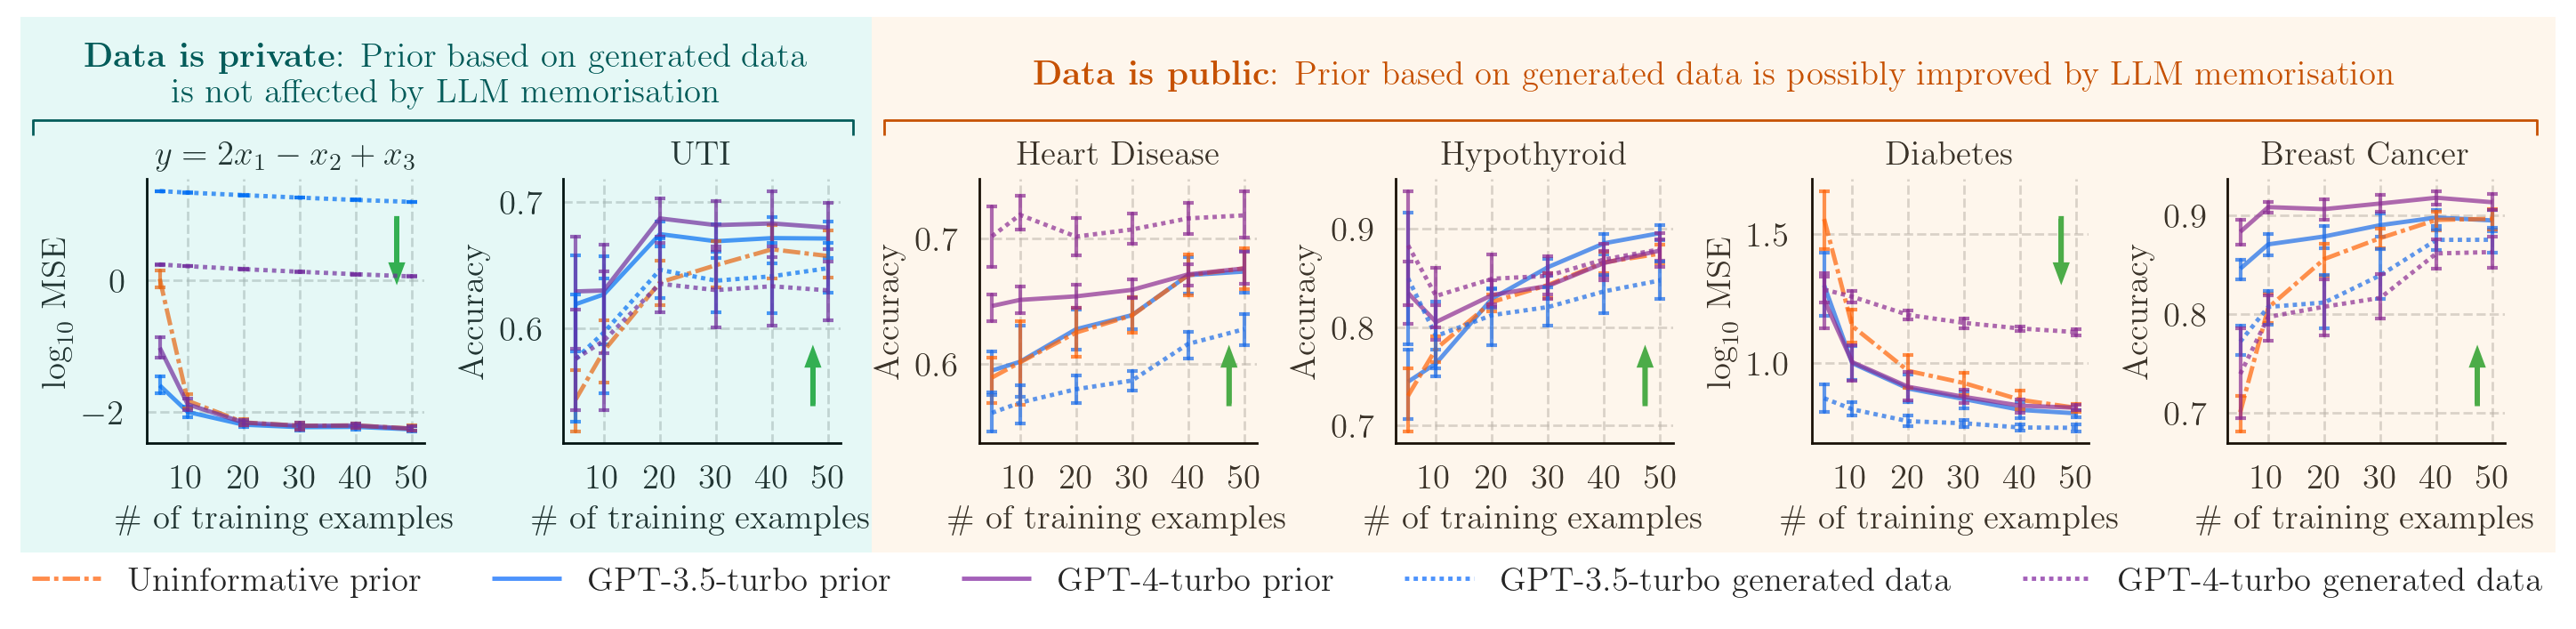

In [13]:
methods_to_plot = [
    "uninformative",
    "gpt_prior",
    "gpt_4_turbo_prior",
    "generated_prior",
    "gpt_4_turbo_generated_prior",
]

fontsize = 14

linewidth_on_plot = 1.75
alpha = 0.7

datasets_to_plot = [
    r"$y = 2 x_1 - x_2 + x_3$",
    "UTI",
    "Heart Disease",
    "Hypothyroid",
    "Diabetes",
    "Breast Cancer",
    #"California Housing",
    #"Wine Quality",
]

with graph_theme():
    plt.close()

    fig, axes = plt.subplots(
        1, len(datasets_to_plot), 
        figsize=(2*linewidth, 0.75*linewidth/1.618)
    )

    for nax, (dataset, ax) in enumerate(
        zip(
            datasets_to_plot,
            axes
        )
    ):

        ax = sns.lineplot(
            data=(
                accuracy_results_line_plot
                .loc[lambda df: df["prior_type"].isin(methods_to_plot)]
                .query("dataset == @dataset")
                .replace({"prior_type": method_names})
                .assign(
                    metrics_to_plot=lambda x: 
                    np.log10(x["metrics_to_plot"].astype(float)) 
                    if dataset in [
                        "California Housing", r"$y = 2 x_1 - x_2 + x_3$", "Diabetes"
                    ]
                    else x["metrics_to_plot"]
                )
            ),
            x="n_data_points_seen",
            y="metrics_to_plot",
            hue="prior_type",
            palette=palette,
            style="prior_type",
            style_order=[
                method_names[m_name]
                for m_name in methods_to_plot
            ],
            alpha=alpha,
            dashes=dashes,
            err_style="bars",
            errorbar=("ci", 95),
            err_kws=dict(
                capsize=2,
                capthick=1.5,
                elinewidth=1.5,
                linewidth=1.5,
            ),
            markersize=6,
            linewidth=linewidth_on_plot,
            ax=ax,
            legend=False
        )

        if nax == 0:
            if dataset in ["California Housing", r"$y = 2 x_1 - x_2 + x_3$", "Diabetes"]:
                ax.set_ylabel(r"$\log_{10}$ MSE", fontsize=fontsize)
            else:
                ax.set_ylabel("Accuracy", fontsize=fontsize)
        else:
            if dataset in ["California Housing", r"$y = 2 x_1 - x_2 + x_3$", "Diabetes"]:
                ax.set_ylabel(r"$\log_{10}$ MSE", fontsize=fontsize)
            else:
                ax.set_ylabel("Accuracy", fontsize=fontsize)
        ax.set_xlabel("\# of training examples", fontsize=fontsize)
        ax.tick_params(axis="both", labelsize=fontsize)
        ax.set_title(dataset, fontsize=fontsize)
        ax.set_xticks(np.arange(0, 51, 10))

        y = (
            0.15 
            if dataset not in ["California Housing", r"$y = 2 x_1 - x_2 + x_3$", "Diabetes"] 
            else 0.85
        )
        dy = (
            0.075*(0.8/0.3)*(1.4/1.6)*5/6
            if dataset not in ["California Housing", r"$y = 2 x_1 - x_2 + x_3$", "Diabetes"] 
            else -0.075*(0.8/0.3)*(1.4/1.6)
        )
        ax.arrow(
            x=0.9, y=y, 
            dx=0.0, dy=dy,
            head_width=0.05/(1.25*1.33)*6/5, 
            head_length=0.025*(1.25*1.33)*(0.5/0.3)*(1.4/1.6)*5/6,
            color='xkcd:medium green',
            alpha=1.0,
            linewidth=2,
            transform=ax.transAxes
        )


    leg = fig.legend(
        loc="lower center",
        labels=[
            method_names[m_name] for m_name in methods_to_plot
        ], 
        handles=[
            plt.Line2D(
                [0,1], [0,1], 
                color=palette[method_names[m_name]], 
                markerfacecolor=palette[method_names[m_name]], 
                markeredgecolor="white",
                markersize=6,
                linewidth=linewidth_on_plot,
                linestyle=(0, dashes[method_names[m_name]]),
                alpha=alpha,
            )
            for m_name in methods_to_plot
        ],
        fontsize=fontsize,
        title_fontsize=fontsize,
        bbox_to_anchor=(0.5, -0.04),
        ncols=5,
        frameon=False,
    )

    pad = 0.0025

    rect = plt.Rectangle(
        (2/6+pad, 0.09), 4/6-pad, 0.91,
        transform=fig.transFigure,
        figure=fig,
        clip_on=False,
        edgecolor="none", 
        facecolor="xkcd:light orange", 
        alpha=0.1,
    )

    fig.add_artist(rect)

    rect = plt.Rectangle(
        (0, 0.09), 2/6+pad, 0.91,
        transform=fig.transFigure,
        figure=fig,
        clip_on=False,
        edgecolor="none", 
        facecolor="xkcd:turquoise", 
        alpha=0.1,
    )

    fig.add_artist(rect)

    fig.text(
        (2/6+pad + 1)/2, 0.9, r"\textbf{Data is public}: "
        "Prior based on generated data is possibly improved by LLM memorisation", 
        fontsize=fontsize, ha="center", va="center", color="xkcd:dark orange"
    )

    fig.text(
        (2/6+pad)/2, 0.9, r"\textbf{Data is private}: "
        "Prior based on generated data\nis not affected by LLM memorisation", 
        fontsize=fontsize, ha="center", va="center", color="xkcd:dark turquoise"
    )

    line_pad_x = 0.005

    fig.add_artist(
        plt.Line2D(
            [2/6+pad+line_pad_x,1-pad-line_pad_x], [0.825,0.825], 
            color="xkcd:dark orange", 
            linewidth=1,
            linestyle=(0, ()),
            alpha=1.0,
        )
    )

    fig.add_artist(
        plt.Line2D(
            [2/6+pad+line_pad_x,2/6+pad+line_pad_x], [0.827,0.8], 
            color="xkcd:dark orange", 
            linewidth=1,
            linestyle=(0, ()),
            alpha=1.0,
        )
    )

    fig.add_artist(
        plt.Line2D(
            [1-pad-line_pad_x,1-pad-line_pad_x], [0.827,0.8], 
            color="xkcd:dark orange", 
            linewidth=1,
            linestyle=(0, ()),
            alpha=1.0,
        )
    )

    fig.add_artist(
        plt.Line2D(
            [0+line_pad_x,2/6-line_pad_x], [0.825,0.825], 
            color="xkcd:dark turquoise", 
            linewidth=1,
            linestyle=(0, ()),
            alpha=1.0,
        )
    )

    fig.add_artist(
        plt.Line2D(
            [0+line_pad_x,0+line_pad_x], [0.827,0.8], 
            color="xkcd:dark turquoise", 
            linewidth=1,
            linestyle=(0, ()),
            alpha=1.0,
        )
    )

    fig.add_artist(
        plt.Line2D(
            [2/6-line_pad_x,2/6-line_pad_x], [0.827,0.8], 
            color="xkcd:dark turquoise", 
            linewidth=1,
            linestyle=(0, ()),
            alpha=1.0,
        )
    )

    fig.subplots_adjust(
        wspace=0.5,
        left=0.05,
        right=0.98,
        top=0.725,
        bottom=0.275,
    )

    fig.savefig("results/elicitation_results_lineplot_with_baseline.pdf")
    fig.savefig("results/elicitation_results_lineplot_with_baseline.svg")
    fig.savefig("results/elicitation_results_lineplot_with_baseline.png", dpi=400)

    plt.show()